In [2]:
from segment_anything import SamPredictor, sam_model_registry
from pathlib import Path
import os

import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import random
from tqdm import tqdm

from bearfacedetection.xml_parser import load_xml

/home/chouffe/miniconda3/envs/fruitpunch_bears/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/chouffe/miniconda3/envs/fruitpunch_bears/lib/python3.9/site-packages/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_5m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/chouffe/miniconda3/envs/fruitpunch_bears/lib/python3.9/site-packages/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_11m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this i

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def get_random_image_data(xml_data):
    idx = random.randint(0, len(xml_data["images"]))
    return xml_data["images"][idx]

## Loading the SAM model

In [5]:
torch.cuda.is_available()

False

In [6]:
sam_hq_checkpoint_path = Path('../../data/06_models/bearfacesegmentation/sam-hq/weights/sam_hq_vit_h.pth')
sam_hq = sam_model_registry["vit_h"](checkpoint=sam_hq_checkpoint_path)

<All keys matched successfully>


## Loading the dataset

In [7]:
base_path = Path('../../data/01_raw/BearID/')
label_path = base_path / 'images_train_without_bc.xml'
xml_data = load_xml(base_path=base_path, filepath=label_path)

In [8]:
xml_data["images"][0]

{'filepath': PosixPath('../../data/01_raw/BearID/images/brooksFalls/je_201708/bf_755/755-scare-d-bear-near-the-north-side-of-brooks-falls_9237775339_o.jpg'),
 'bboxes': [{'top': 1059,
   'left': 1172,
   'width': 200,
   'height': 200,
   'parts': {'htop': {'x': 1283, 'y': 1068},
    'lear': {'x': 1335, 'y': 1080},
    'rear': {'x': 1228, 'y': 1084},
    'nose': {'x': 1279, 'y': 1197},
    'leye': {'x': 1324, 'y': 1132},
    'reye': {'x': 1246, 'y': 1133}}}],
 'size': {'width': 2000, 'height': 1500}}

## Test SAM with different prompts

In [9]:
predictor = SamPredictor(sam_hq)

In [10]:
def load_image(image_data: dict):
    image_filepath = image_data["filepath"]
    image = cv2.imread(str(image_filepath))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def show_image(image):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.axis('on')
    plt.show()

def show_mask_overlay(image, score, mask, input_point, input_label):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

def show_all_masks(image, masks, scores, input_point, input_label):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        show_mask(mask, plt.gca())
        show_points(input_point, input_label, plt.gca())
        plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

def select_best(masks, scores):
    best_idx = np.argmax(scores)
    return masks[best_idx], scores[best_idx]

In [11]:
random.seed(42)
image_data = get_random_image_data(xml_data)
parts = image_data["bboxes"][0]["parts"]
image = load_image(image_data)
predictor.set_image(image)

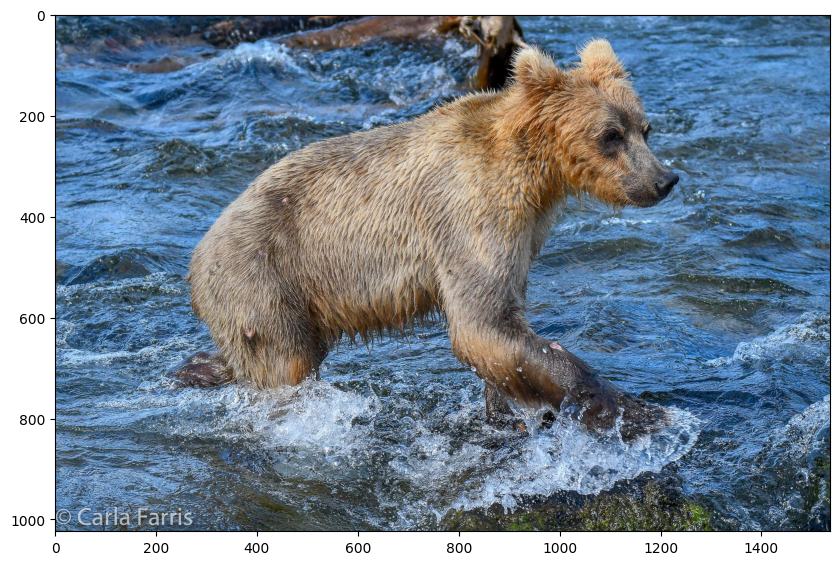

In [12]:
show_image(image)

### point labels: nose

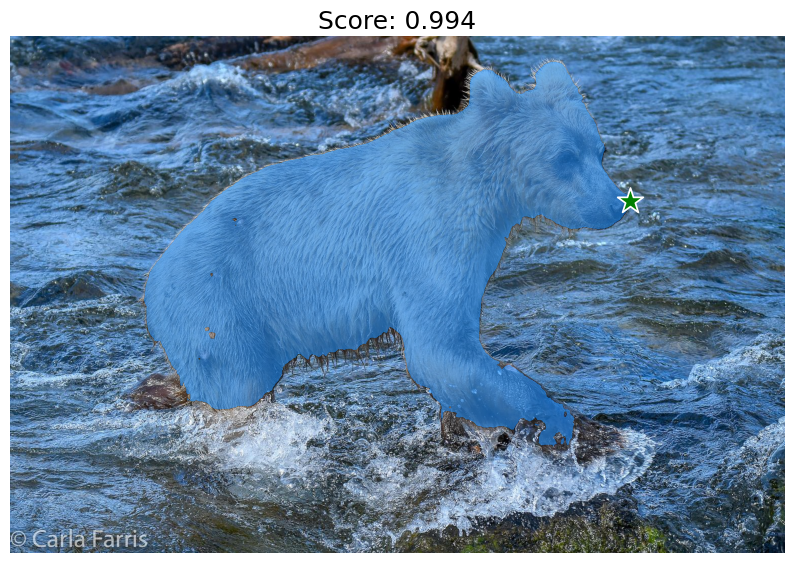

In [13]:
input_point = np.array([[parts["nose"]["x"], parts["nose"]["y"]]])
input_label = np.array([1])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

best_mask, best_score = select_best(masks, scores)
show_mask_overlay(image, best_score, best_mask, input_point, input_label)

### point labels: nose + eyes

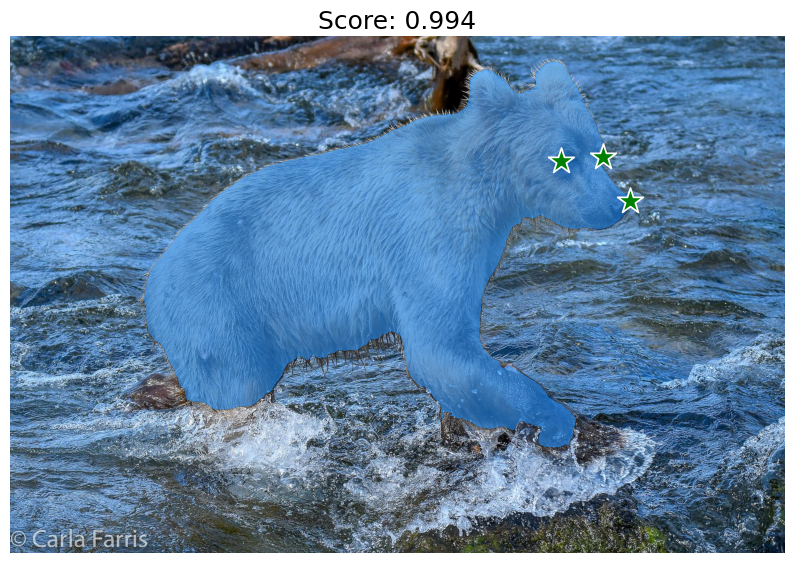

In [14]:
input_point = np.array([
    [parts["nose"]["x"], parts["nose"]["y"]],
    [parts["leye"]["x"], parts["leye"]["y"]],
    [parts["reye"]["x"], parts["reye"]["y"]],
])
input_label = np.array([1, 1, 1])

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

best_mask, best_score = select_best(masks, scores)
show_mask_overlay(image, best_score, best_mask, input_point, input_label)

### point labels: nose + eyes + htop + ears

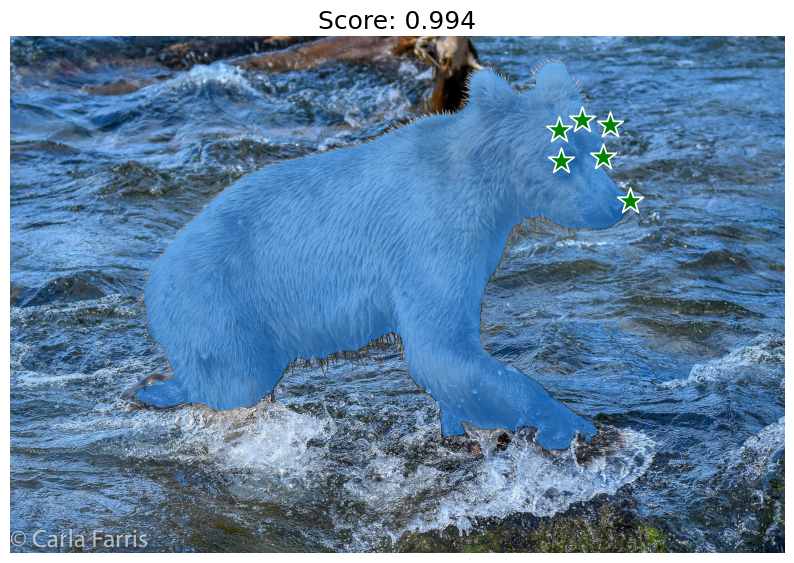

In [15]:
input_point = np.array([
    [parts["nose"]["x"], parts["nose"]["y"]],
    [parts["leye"]["x"], parts["leye"]["y"]],
    [parts["reye"]["x"], parts["reye"]["y"]],
    [parts["htop"]["x"], parts["htop"]["y"]],
    [parts["rear"]["x"], parts["rear"]["y"]],
    [parts["lear"]["x"], parts["lear"]["y"]],
])
input_label = np.array([1, 1, 1, 1, 1, 1])

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

best_mask, best_score = select_best(masks, scores)
show_mask_overlay(image, best_score, best_mask, input_point, input_label)

### Comparisons

In [16]:
def compare_prompts(image_data):
    parts = image_data["bboxes"][0]["parts"]
    image = load_image(image_data)
    predictor.set_image(image)

    # Point Prompt: Nose 
    input_point_nose = np.array([[parts["nose"]["x"], parts["nose"]["y"]]])
    input_label_nose = np.array([1])
    
    masks_nose, scores_nose, _ = predictor.predict(
        point_coords=input_point_nose,
        point_labels=input_label_nose,
        multimask_output=True,
    )
    
    best_mask_nose, best_score_nose = select_best(masks_nose, scores_nose)

    input_point_nose_eyes = np.array([
        [parts["nose"]["x"], parts["nose"]["y"]],
        [parts["leye"]["x"], parts["leye"]["y"]],
        [parts["reye"]["x"], parts["reye"]["y"]],
    ])
    input_label_nose_eyes = np.array([1, 1, 1])
    
    masks_nose_eyes, scores_nose_eyes, _ = predictor.predict(
        point_coords=input_point_nose_eyes,
        point_labels=input_label_nose_eyes,
        multimask_output=True,
    )

    best_mask_nose_eyes, best_score_nose_eyes = select_best(masks_nose_eyes, scores_nose_eyes)

    input_point_nose_eyes_ears = np.array([
        [parts["nose"]["x"], parts["nose"]["y"]],
        [parts["leye"]["x"], parts["leye"]["y"]],
        [parts["reye"]["x"], parts["reye"]["y"]],
        [parts["htop"]["x"], parts["htop"]["y"]],
        [parts["rear"]["x"], parts["rear"]["y"]],
        [parts["lear"]["x"], parts["lear"]["y"]],
    ])
    input_label_nose_eyes_ears = np.array([1, 1, 1, 1, 1, 1])
    
    masks_nose_eyes_ears, scores_nose_eyes_ears, _ = predictor.predict(
        point_coords=input_point_nose_eyes_ears,
        point_labels=input_label_nose_eyes_ears,
        multimask_output=True,
    )

    best_mask_nose_eyes_ears, best_score_nose_eyes_ears = select_best(masks_nose_eyes_ears, scores_nose_eyes_ears)

    
    fig, _ = plt.subplots(nrows=1, ncols=4, figsize=(18,10))
    ax1, ax2, ax3, ax4 = fig.get_axes()
    ax1.imshow(image)
    show_mask(best_mask_nose, ax2)
    show_points(input_point_nose, input_label_nose, ax2)
    show_mask(best_mask_nose_eyes, ax3)
    show_points(input_point_nose_eyes, input_label_nose_eyes, ax3)
    show_mask(best_mask_nose_eyes_ears, ax4)
    show_points(input_point_nose_eyes_ears, input_label_nose_eyes_ears, ax4)

    plt.show()

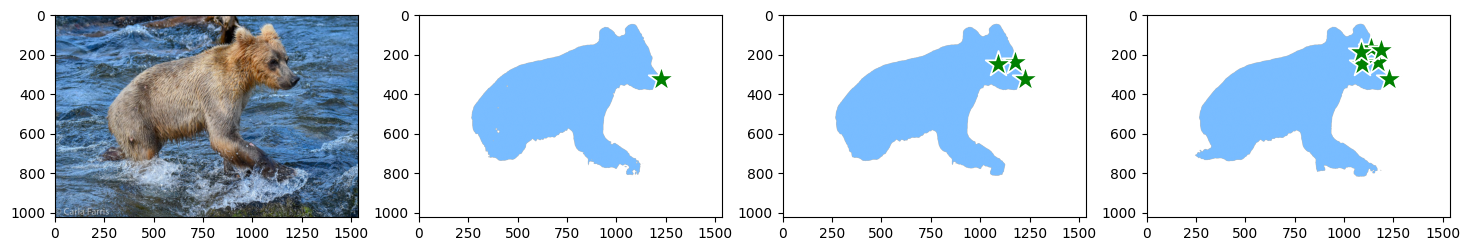

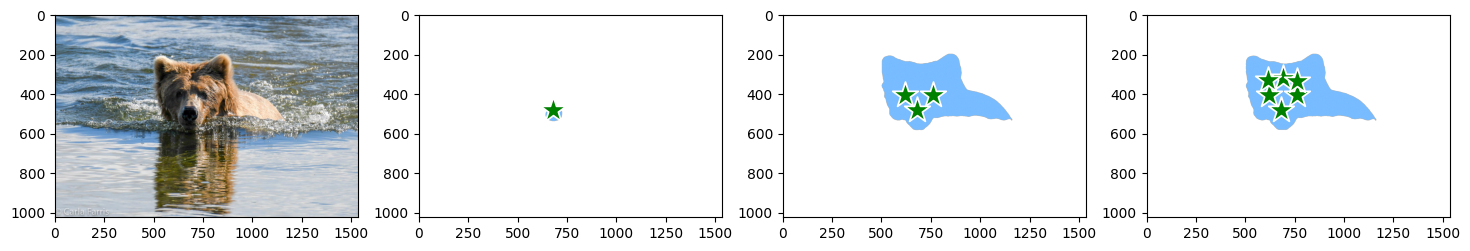

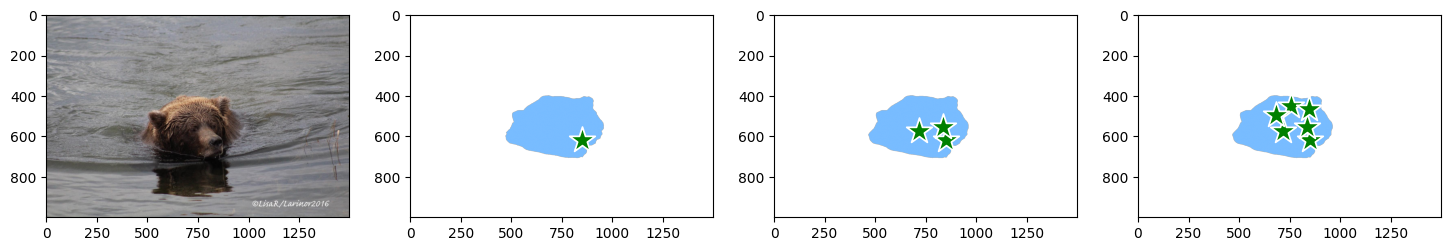

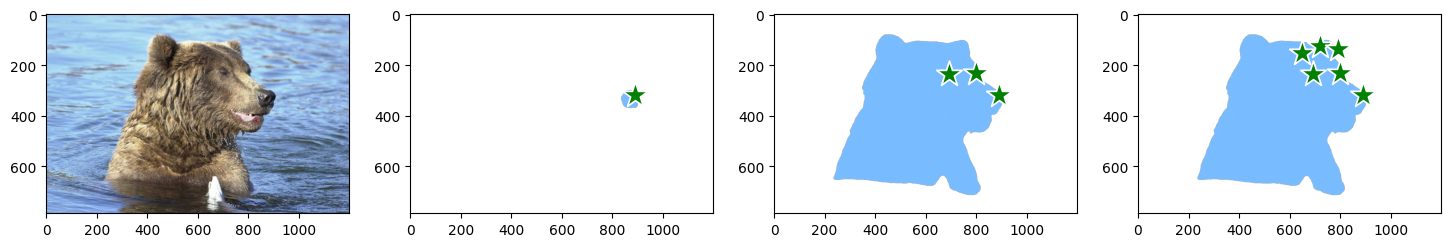

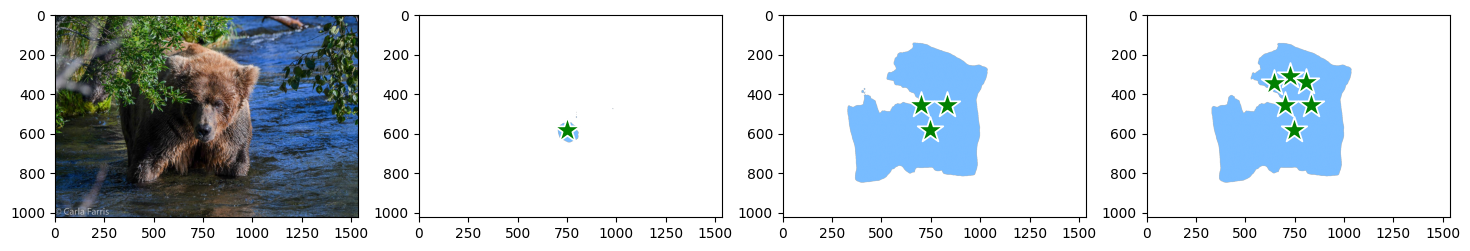

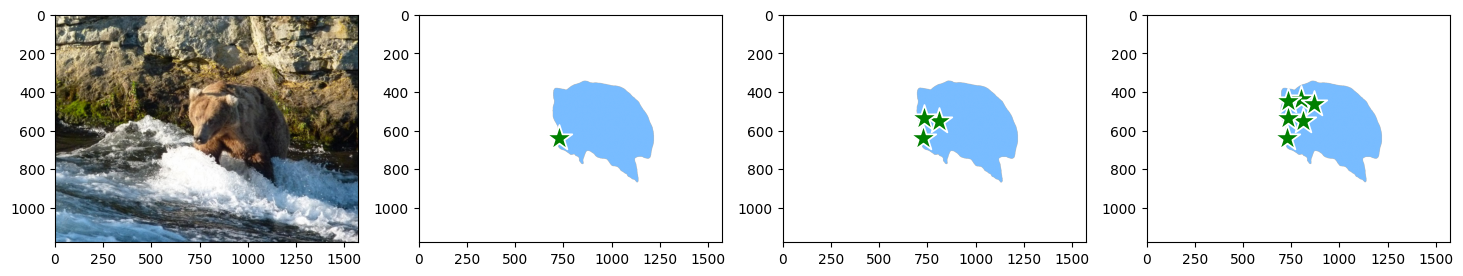

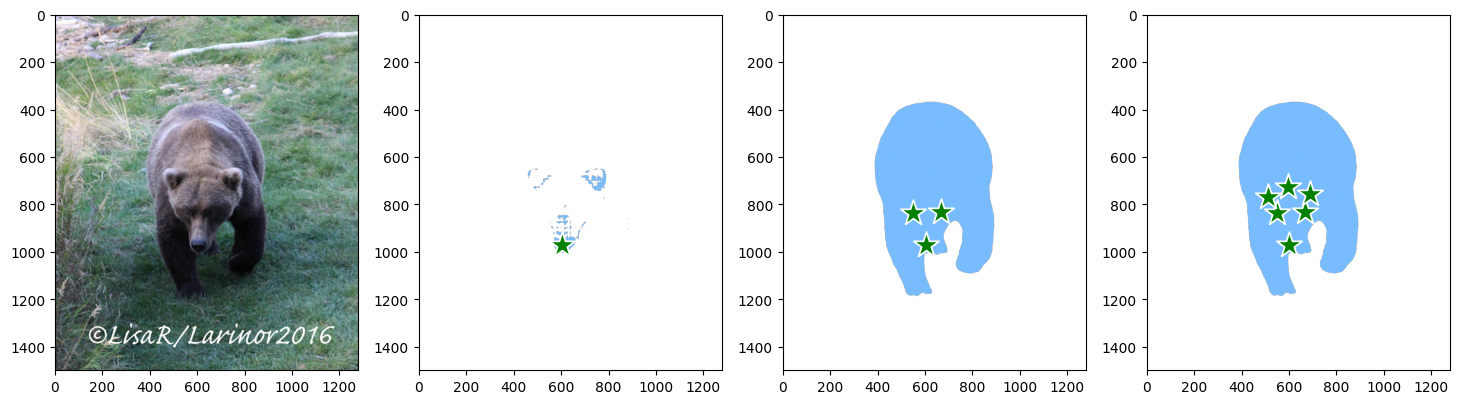

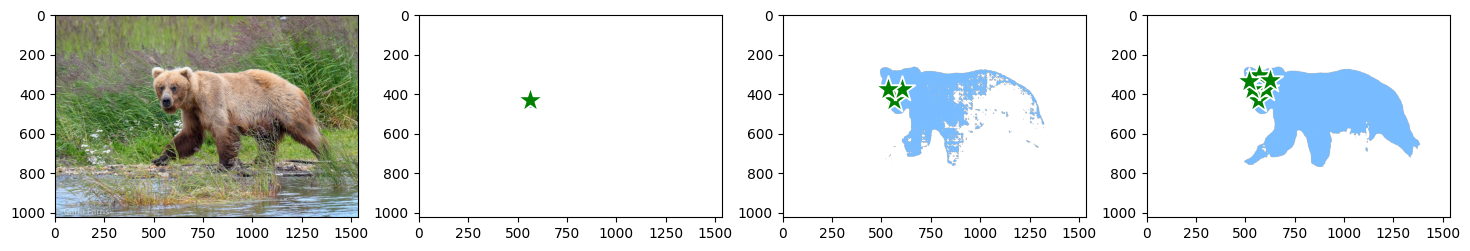

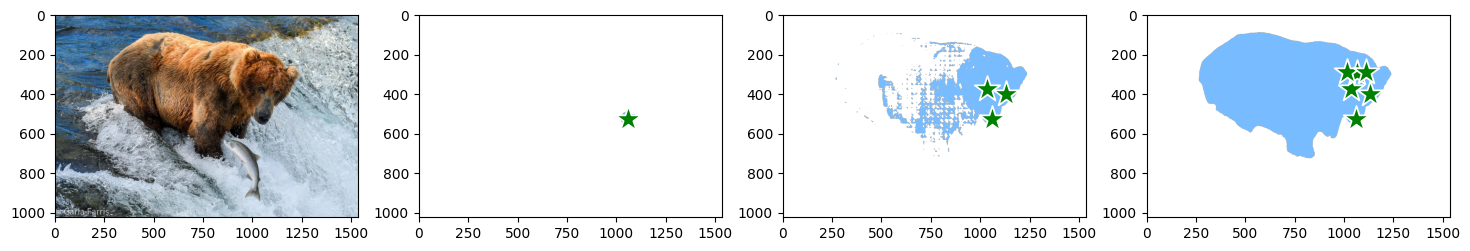

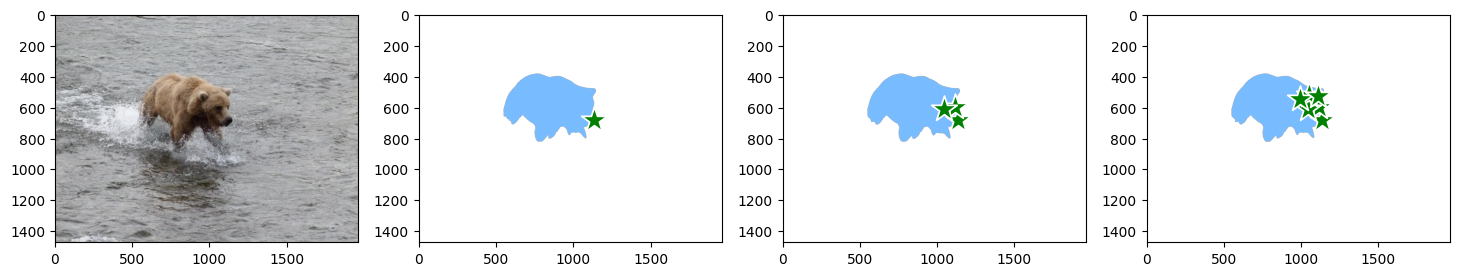

In [17]:
random.seed(42)

for _ in range(10):
    image_data = get_random_image_data(xml_data)
    compare_prompts(image_data)